# Coronavirus
Statistics about coronavirus in Czechia.  
Filip Gregor, 2020 

In [20]:
tests = "https://onemocneni-aktualne.mzcr.cz/api/v2/covid-19/nakazeni-vyleceni-umrti-testy.csv"
daily_cases = "https://onemocneni-aktualne.mzcr.cz/api/v2/covid-19/kraj-okres-nakazeni-vyleceni-umrti.csv"

Import python libraries

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
import numpy as numpy
from lmfit.models import ExponentialModel
from lmfit.models import StepModel

Read the data and save them into panda dataframe.

In [22]:
corona = pd.read_csv(tests)
# Translate column headers into english. 
corona = corona.rename({
    'datum' : 'date',
    'kumulativni_pocet_nakazenych' : 'positive_acc',
    'kumulativni_pocet_vylecenych' : 'cured',
    'kumulativni_pocet_umrti' : 'deaths',
    'kumulativni_pocet_testu' : 'tests',
}, axis = 1)
corona.head()

,date,positive_acc,cured,deaths,tests
0,2020-01-27,0,0,0,20
1,2020-01-28,0,0,0,28
2,2020-01-29,0,0,0,33
3,2020-01-30,0,0,0,34
4,2020-01-31,0,0,0,37


Change the 'date' column into datetime datatype, sort values by date and reset indexes.

In [23]:
# Convert date to datetype 
corona['date'] = pd.to_datetime(corona['date'], format='%Y-%m-%d')

# Sort values by date and reset indexes
corona.sort_values('date')
corona = corona.reset_index(drop=True)
corona.tail()

,date,positive_acc,cured,deaths,tests
191,2020-08-05,17521,12550,389,728801
192,2020-08-06,17735,12646,390,735626
193,2020-08-07,18058,12777,390,743766
194,2020-08-08,18233,12783,390,748872
195,2020-08-09,18355,12785,390,748872


Create new column with daily cases and daily tests, also one with total cases at one time(total_acc - cured).

In [24]:
corona['positive_curr'] = corona['positive_acc'] - corona['cured']
corona['daily_positives'] = corona['positive_acc'] - corona['positive_acc'].shift(1)
corona['daily_tests'] = corona['tests'] - corona['tests'].shift(1)
corona.tail()

,date,positive_acc,cured,deaths,tests,positive_curr,daily_positives,daily_tests
191,2020-08-05,17521,12550,389,728801,4971,240.0,6693.0
192,2020-08-06,17735,12646,390,735626,5089,214.0,6825.0
193,2020-08-07,18058,12777,390,743766,5281,323.0,8140.0
194,2020-08-08,18233,12783,390,748872,5450,175.0,5106.0
195,2020-08-09,18355,12785,390,748872,5570,122.0,0.0


Remove leading rows with zero cases and remove last row, because it often has incomplete data.

In [25]:
corona_Pmask = corona['daily_positives'] > 0

# Count how many leading rows have 0 cases, stop when we encounter a row that has cases.
count = 0
for x in corona_Pmask:
    if x:
        break
    count += 1
    
# Remove first 'count' rows.
corona = corona.iloc[count:]

# Remove last row, it often has incomplete number of tests.
corona = corona[:-1]

# Reset indexes.
corona = corona.reset_index(drop=True)
corona['day'] = corona.index

corona.info()
corona

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161 entries, 0 to 160
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             161 non-null    datetime64[ns]
 1   positive_acc     161 non-null    int64         
 2   cured            161 non-null    int64         
 3   deaths           161 non-null    int64         
 4   tests            161 non-null    int64         
 5   positive_curr    161 non-null    int64         
 6   daily_positives  161 non-null    float64       
 7   daily_tests      161 non-null    float64       
 8   day              161 non-null    int64         
dtypes: datetime64[ns](1), float64(2), int64(6)
memory usage: 11.4 KB


,date,positive_acc,cured,deaths,tests,positive_curr,daily_positives,daily_tests,day
0,2020-03-01,3,0,0,211,3,3.0,11.0,0
1,2020-03-02,3,0,0,262,3,0.0,51.0,1
2,2020-03-03,5,0,0,340,5,2.0,78.0,2
3,2020-03-04,6,0,0,407,6,1.0,67.0,3
4,2020-03-05,9,0,0,483,9,3.0,76.0,4
...,...,...,...,...,...,...,...,...,...
156,2020-08-04,17281,12462,388,722108,4819,289.0,8144.0,156
157,2020-08-05,17521,12550,389,728801,4971,240.0,6693.0,157
158,2020-08-06,17735,12646,390,735626,5089,214.0,6825.0,158
159,2020-08-07,18058,12777,390,743766,5281,323.0,8140.0,159


# Simple Graphs

### Positive cases

Text(0.5, 1.0, 'Positive cases')

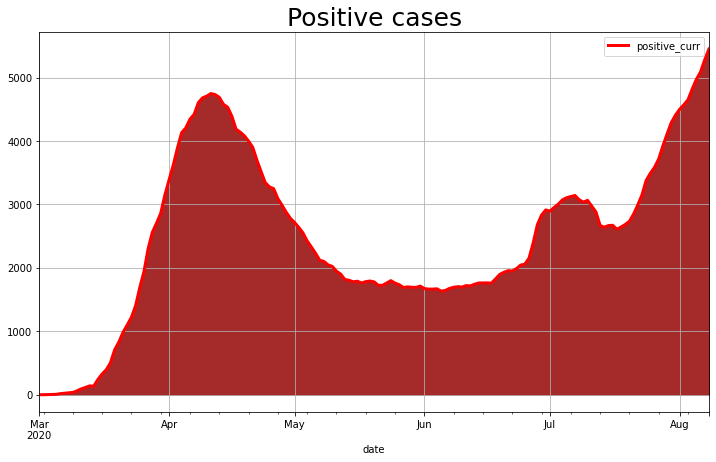

In [26]:
ax = corona.plot(x='date', y='positive_curr', figsize=(12,7), grid=True, lw=3, color='red')

# Pandas does not convert pandas series of datetime64 to something matplotlib can recognize,
# fill_between will have no effect, thats why we're creating a numpy array, more on this: https://stackoverflow.com/questions/29329725/pandas-and-matplotlib-fill-between-vs-datetime64
d = corona['date'].values

ax.fill_between(d,  0, corona['positive_curr'], color='brown')
ax.set_title("Positive cases", fontsize=25) 

### Tests done.

Text(0.5, 1.0, 'Tests done')

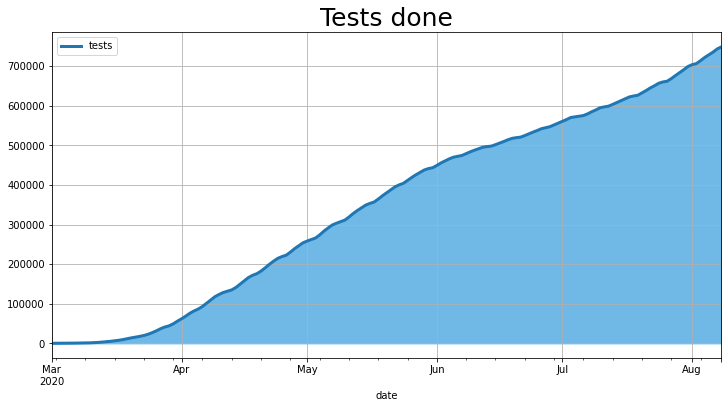

In [27]:
ax = corona.plot(x='date', y='tests', figsize=(12,6), grid=True, lw=3)

ax.fill_between(d, 0, corona['tests'], color='#70b9e6')
ax.set_title('Tests done', fontsize=25)

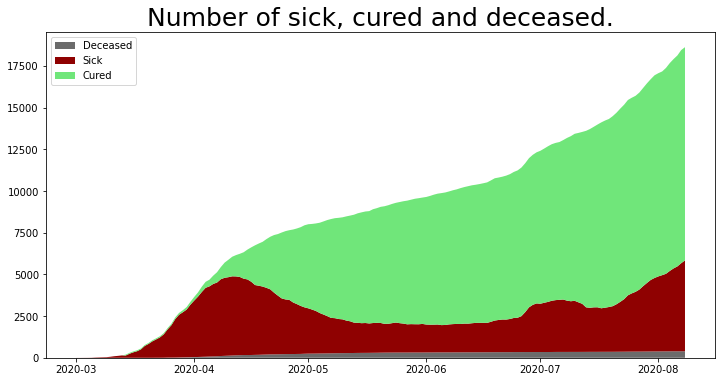

In [28]:
colors = ['#6b6b6b','#8f0101','#70e67a']
fig, ax = plt.subplots(figsize=(12,6))
ax.stackplot(d, corona['deaths'], corona['positive_curr'], corona['cured'], labels=('Deceased', 'Sick', 'Cured'), colors=colors)
ax.legend(loc='upper left')
ax.set_title('Number of sick, cured and deceased.', fontsize=25)
plt.show()

Positive cases in logarithmic scale.

Text(0.5, 1.0, 'Positive cases in logarithmic scale.')

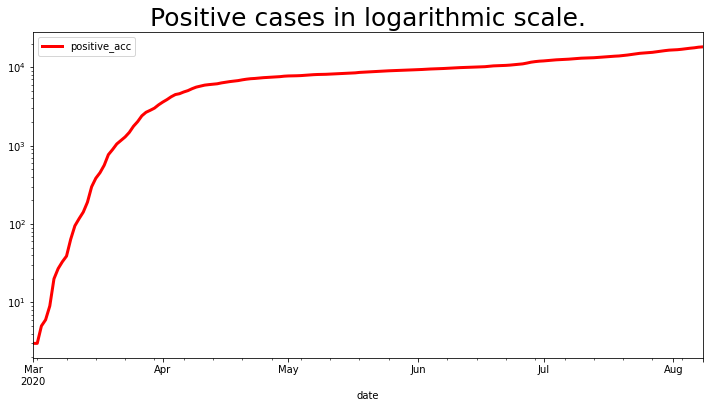

In [141]:
ax = corona.plot(x='date', y='positive_acc', color='red', figsize=(12,6),lw=3, logy=True)
ax.set_title("Positive cases in logarithmic scale.", fontsize=25)

Daily positives summed up for each month.

Text(0.5, 1.0, 'Positive cases for each month.')

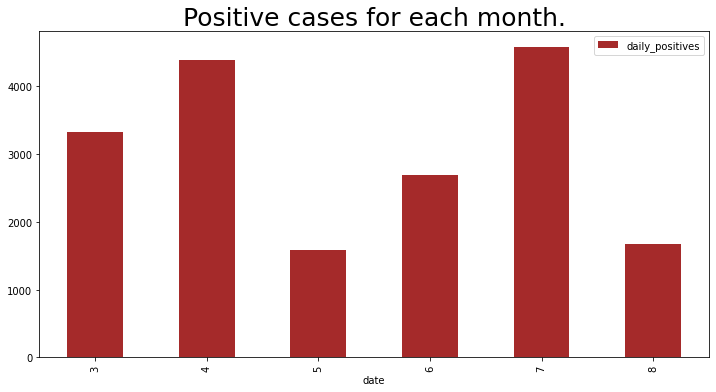

In [142]:
# Group up the values by month and sum other rows
g = corona.groupby(corona.date.dt.month).sum()
ax = g.plot( y='daily_positives', kind='bar',figsize=(12,6), color='brown')
ax.set_title("Positive cases for each month.", fontsize=25)

Text(0.5, 1.0, 'Tests done for each month.')

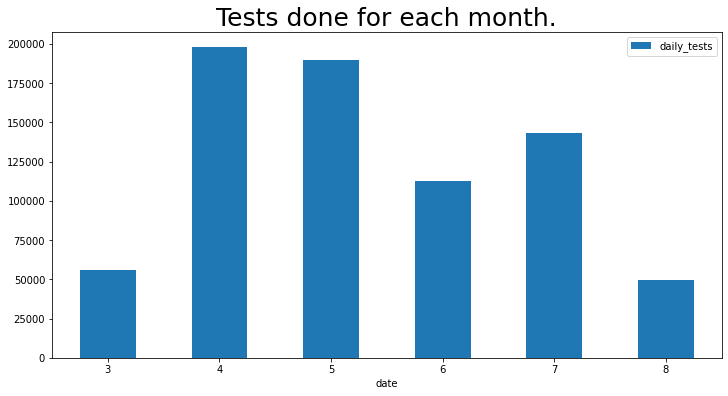

In [184]:
ax = g.plot(y='daily_tests', kind='bar', figsize=(12,6), rot=0)
ax.set_title("Tests done for each month.", fontsize=25)

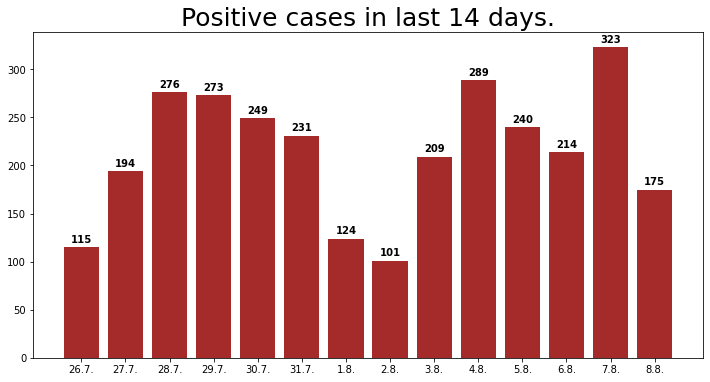

In [221]:
# Format function to return 'day'.'month'. from datetime.
def line_format(x):
    return "{}.{}.".format(x.date().day, x.date().month)

# Get the last fourteen rows.
corona_last = corona[-14:]
fig, ax = plt.subplots(figsize=(12,6))

# Plot last fourteen days.
bars = ax.bar(corona_last['date'], corona_last['daily_positives'], color='brown')

# Create the x_ticks from the dates, also format them.
ax.set_xticks(corona_last['date'])
ax.set_xticklabels(map(lambda x : line_format(x), corona_last.date))
ax.set_title("Positive cases in last 14 days.", fontsize=25)

# For each bar, write the number of cases (which is the bar height) at the top.
for rect in bars:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2., height + 3, '{}'.format(int(height)), ha='center', va='bottom', weight='heavy')
plt.show()

# Exponential growth.
Plot exponential through the data and check if it still grows exponentially.
Inspired by https://kam.fit.cvut.cz/deploy/coronavirus/ by Tomáš Kalvoda.

We will use the following exponential function. Lets briefly analyze it first.
$$ amplitude \cdot e^{x/decay} $$

In [37]:
def exp_decay(x, ampl, decay):
    return ampl * np.exp(x / decay)

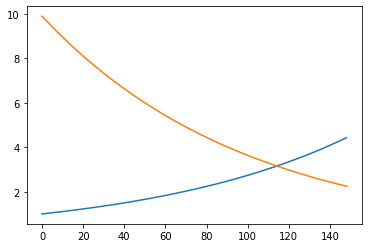

In [40]:
exp_values_neg = [exp_decay(x, 10, -100) for x in range(1, 150)]
exp_values = [exp_decay(x, 1, 100) for x in range(1, 150)]

plt.plot(range(0,len(exp_values)), exp_values)
plt.plot(range(0,len(exp_values_neg)), exp_values_neg)
plt.show()

We will have to have bigger amplitude.

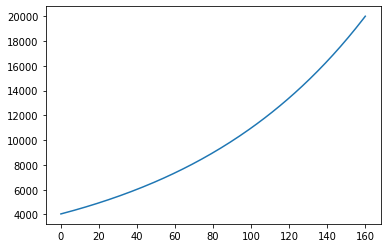

In [43]:
sugg_ampl, sugg_decay = 4000, 100
exp_values = [exp_decay(x, sugg_ampl, sugg_decay) for x in range(1, len(corona.index) + 1)]
plt.plot(range(0, len(exp_values)), exp_values)
plt.show()

Now, we need to give curve_fit a push to make it work, lets give it the values we guessed as a starting point.

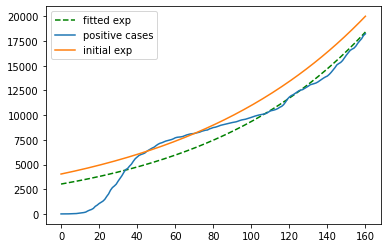

Amplitude: 3024.9144130961695, Decay: 88.57938173991606


In [45]:
popt, pcov = curve_fit(exp_decay, corona['day'], corona['positive_acc'], p0=[sugg_ampl, sugg_decay])
plt.plot(corona['day'], exp_decay(corona['day'], *popt), 'g--', label='fitted exp')
plt.plot(corona['day'], corona['positive_acc'], label='positive cases')
plt.plot(corona['day'], exp_values, label='initial exp')
plt.legend()
plt.show()
print("Amplitude: {}, Decay: {}".format(popt[0], popt[1]))


Quotient by which positive cases go up every day.

In [46]:
q=np.exp(1/popt[1])
q

1.0113532735968915

Which is approx.

In [47]:
print( '{:.2f}% increase every day'.format((q - 1) * 100))

1.14% increase every day


## Calculate quotient for every day

In [107]:
# Here we will use more advanced model, which uses the same function but has -x in the exponent instead of x.
from lmfit.models import ExponentialModel

# Create new column
corona['quotient'] = 1.0

# Create the model
model = ExponentialModel()

# Iterate over all rows
for i, row in corona.iterrows():
    # Skip the first 10 rows, the jumps we're big so they wouldn't be accurate.
    if i < 10:
        continue
    
    # Get i+1 rows of our dataframe.
    tmpCorona = corona[:i+1]

    # Guess the initial parameters. We did this manually before, now lmfit does it for us.
    params = model.guess(tmpCorona['positive_acc'], x=tmpCorona['day'])
    
    # Get the actual fitted result.
    result = model.fit(tmpCorona['positive_acc'], params, x=tmpCorona['day'])
    
    # Save it to dataframe.
    corona.at[i, 'quotient'] = np.exp(-1/result.params['decay'])

In [108]:
corona.tail()

,date,positive_acc,cured,deaths,tests,positive_curr,daily_positives,daily_tests,day,quotient
156,2020-08-04,17281,12462,388,722108,4819,289.0,8144.0,156,1.030017
157,2020-08-05,17521,12550,389,728801,4971,240.0,6693.0,157,1.029779
158,2020-08-06,17735,12646,390,735626,5089,214.0,6825.0,158,1.029546
159,2020-08-07,18058,12777,390,743766,5281,323.0,8140.0,159,1.029319
160,2020-08-08,18233,12783,390,748872,5450,175.0,5106.0,160,1.029096


### Quotient evolution.

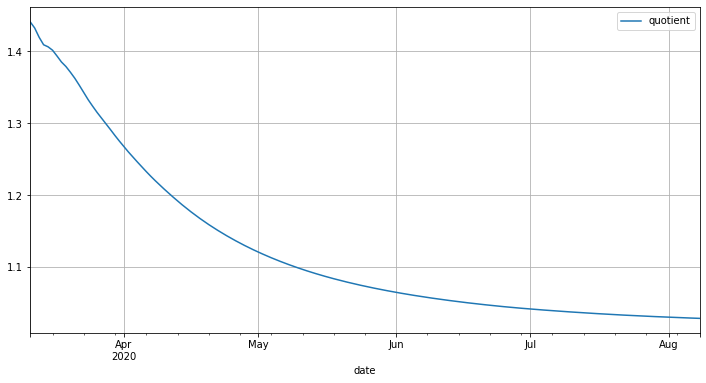

In [109]:
corona[10:].plot(x='date', y='quotient',  figsize=(12,6), grid=True)